In [49]:
from __future__ import division
import numpy as np
import os
from PIL import Image
from IPython.display import display
import glob
import random
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib ipympl

In [2]:
root = os.getcwd()
data_path = "extracted_images"
dataset_dir ="dataset"

In [77]:
def generate_datasets(data_dir, out_folder, symbols_required):
    """
    Divide features and label in two different datasets
    """
    from shutil import copyfile
    
    if os.path.isdir(out_folder):
        raise ValueError("dataset folder already present.")
        
    else:
        features_dir = os.path.join(out_folder, "features")
        labels_dir = os.path.join(out_folder, "labels")
        
        # Make base folder structure
        os.mkdir(out_folder)
        os.mkdir(features_dir)
        os.mkdir(labels_dir)
    
    # Get symbols class names
    if symbols_required:
        data_folders = symbols_required
    else:
        data_folders = os.listdir(data_dir)
    
   # Iterate over each class 
    for folder in tqdm(data_folders):
        
        if folder== ".":
                continue
        
        symbols = os.listdir(os.path.join(data_dir, folder))
        print("Copying", folder, " counts:", len(symbols))
        os.mkdir(os.path.join(features_dir, folder))
        os.mkdir(os.path.join(labels_dir, folder))
        for symbol in symbols:
            if symbol[0]== ".":
                continue
            old_path = os.path.join(data_dir, os.path.join(folder, symbol))
            if "_" in symbol:
                new_path = os.path.join(labels_dir, os.path.join(folder, symbol))
            else:
                new_path = os.path.join(features_dir, os.path.join(folder, symbol))
            copyfile(old_path, new_path)

In [78]:
symbols=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "+", "-", "times", "div", "forward_slash", "(", ")", "[", "]",
         "{", "}", "!", ","]
generate_datasets("extracted_images", dataset_dir, symbols)

HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

Copying 0  counts: 6914
Copying 1  counts: 26520
Copying 2  counts: 26141
Copying 3  counts: 10909
Copying 4  counts: 7396
Copying 5  counts: 3545
Copying 6  counts: 3118
Copying 7  counts: 2909
Copying 8  counts: 3068
Copying 9  counts: 3737
Copying +  counts: 25112
Copying -  counts: 33997
Copying times  counts: 3251
Copying div  counts: 868
Copying forward_slash  counts: 199
Copying (  counts: 14294
Copying )  counts: 14355
Copying [  counts: 779
Copying ]  counts: 780
Copying {  counts: 376
Copying }  counts: 377
Copying !  counts: 1300
Copying ,  counts: 1906


In [70]:
def disp_sample(folders_path, sample_size):
    basename = os.path.basename(folders_path)
    folders = os.listdir(folders_path)
    for folder in folders:
        if folder.startswith("."):
            continue
        print("{}/{}".format(basename, folder))
        folder_path = os.path.join(folders_path, folder)
        image_files = os.listdir(folder_path)
        if len(image_files) == 0:
            continue
        image_samples = random.sample(image_files, sample_size)
        for image in image_samples:
            image_file = os.path.join(folders_path, os.path.join(folder, image))
            i = Image.open(image_file)
            display(i)

features/{


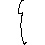

features/3


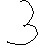

features/-


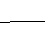

features/times


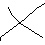

features/9


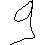

features/1


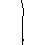

features/]


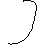

features/2


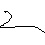

features/}


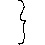

features/+


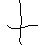

features/0


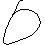

features/8


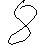

features/,


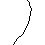

features/!


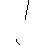

features/5


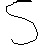

features/4


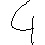

features/)


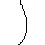

features/6


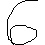

features/forward_slash
features/7


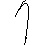

features/[


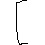

features/div


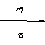

features/(


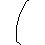

In [79]:
disp_sample("dataset/features", 1)

labels/{


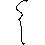

labels/3


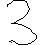

labels/-


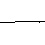

labels/times


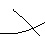

labels/9


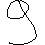

labels/1


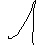

labels/]


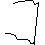

labels/2


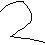

labels/}


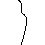

labels/+


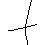

labels/0


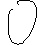

labels/8


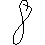

labels/,


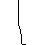

labels/!


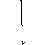

labels/5


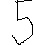

labels/4


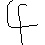

labels/)


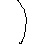

labels/6


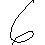

labels/forward_slash


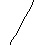

labels/7


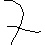

labels/[


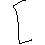

labels/div


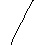

labels/(


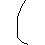

In [80]:
disp_sample("dataset/labels", 1)

## Create fake dataset for object recognition
Create a fake dataset of fixed sized images. 

In [197]:
def pick_random_samples(folders_path, max_sample_size, random_resize=False):
    folders = random.sample(os.listdir(folders_path), 5)
    images = []
    for folder in folders:
        folder_path = os.path.join(folders_path, folder)
        image_files = os.listdir(folder_path)
        if len(image_files) == 0:
            continue
        
        sample_size = random.randint(1, max_sample_size)
        image_samples = random.sample(image_files, sample_size)
        for image in image_samples:
            image_file = os.path.join(folders_path, os.path.join(folder, image))
            i = Image.open(image_file)
            if random_resize:
                m = random.uniform(0.5, 1)
                w, h = i.width, i.height,
                i = i.resize((int(w * m), int(h * m)), Image.ANTIALIAS)
            images.append((i, folder))
            # display(i)
    return images

In [201]:
def create_one_composite_sample():

    images_data = pick_random_samples("dataset/features", max_sample_size=2, random_resize=True)
    if len(images_data) > 0:
        images, class_names = zip(*images_data)
    else:
        print(images_data)
    
    new_im = Image.new('RGB', (300, 300), color='white')
    bboxes = []
    labels = [] 

    def intersect(bbox1, bbox2):
           return (abs(bbox1["x"] - bbox2["x"]) < abs(bbox1["w"] + bbox2["w"]) / 2) and (abs(bbox1["y"] - bbox2["y"]) < (abs(bbox1["h"] + bbox2["h"]) / 2))

    for i in range(len(images)):
        img = images[i]
        pix = np.asarray(img)
        idx = np.where(pix-255) # Drop the color when finding edges
        crop_mask = list(map(min,idx))[::-1] + list(map(max,idx))[::-1]
        img = img.crop(crop_mask)
        
        bbox_offset_px = 2
        
        min_x, max_x = img.width - bbox_offset_px, new_im.width - img.width - bbox_offset_px
        min_y, max_y = img.height - bbox_offset_px, new_im.height - img.height - bbox_offset_px

        x = random.randint(min_x, max_x)
        y = random.randint(min_y, max_y)
        bbox = {
            "x": x - bbox_offset_px,
            "y": y - bbox_offset_px,
            "w": img.width + bbox_offset_px * 2,
            "h": img.height + bbox_offset_px * 2
        }
        j = 0
        hasCollision = False
        while j < len(labels):
            if j == i:
                continue

            if intersect(bbox, labels[j]["bbox"]):
                x = random.randint(min_x, max_x)
                y = random.randint(min_y, max_y)
                bbox = {
                    "x": x - bbox_offset_px,
                    "y": y - bbox_offset_px,
                    "w": img.width + bbox_offset_px * 2,
                    "h": img.height + bbox_offset_px * 2
                }
                j = 0
                continue
            j += 1
        labels.append({
            "class_name": class_names[i],
            "bbox": bbox
        })
        # bboxes.append(bbox)
        
        new_im.paste(img, (x, y))
    return new_im, labels

In [206]:
img, labels = create_one_composite_sample()
class_names = [l["class_name"] for l in labels]
bboxes = [l["bbox"] for l in labels]

fig = plt.figure()
plt.imshow(img)
[plt.gca().add_patch(Rectangle((label["bbox"]["x"], label["bbox"]["y"]), label["bbox"]["w"], label["bbox"]["h"], ec='r', fc='none')) for label in labels]
[plt.gca().text(label["bbox"]["x"], label["bbox"]["y"], label["class_name"]) for label in labels]
img.save("./test", "png")

for label in labels:
    print(" ".join([label["class_name"], 
                    str(label["bbox"]["x"]), 
                    str(label["bbox"]["x"] + label["bbox"]["w"]), 
                    str(label["bbox"]["y"]), 
                    str(label["bbox"]["y"] + label["bbox"]["h"])]))


FigureCanvasNbAgg()

9 233 257 142 173
{ 223 241 58 103
1 193 218 147 189
1 281 295 108 155
8 248 272 274 299
[ 165 199 224 269
[ 62 81 152 183


In [212]:
plt.close('all')

In [220]:
def generate_composite_dataset(path, num_samples):
    if os.path.isdir(path):
        raise ValueError("Folder already exists")
    else:
        features_path = os.path.join(path, "features")
        labels_path = os.path.join(path, "labels")
        os.mkdir(path)
        os.mkdir(features_path)
        os.mkdir(labels_path)
        
    for i in range(num_samples):
        img, labels = create_one_composite_sample()
        img.save(os.path.join(features_path, "{}.png".format(i)))
           
        strings = [" ".join([label["class_name"], 
                    str(label["bbox"]["x"]), 
                    str(label["bbox"]["x"] + label["bbox"]["w"]), 
                    str(label["bbox"]["y"]), 
                    str(label["bbox"]["y"] + label["bbox"]["h"])]) for label in labels]
        
        with open(os.path.join(labels_path, "{}.txt".format(i)), "w") as text_file:
            text_file.write("\n".join(strings))

In [221]:
generate_composite_dataset("fake_dataset", 5)